In [3]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set('talk')
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'medium',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
plt.rcParams.update(params)

In [4]:
models = ['resnet', 'densenet', 'b-resnet', 'b-densenet', 'msdnet']

pc_runs = {
    'resnet': pd.read_csv('resnet_conv_inference_test.csv', index_col=0),
    'densenet': pd.read_csv('dense_conv_inference_test.csv', index_col=0),
    'b-resnet': pd.read_csv('resnet101_all_inference_test.csv', index_col=0),
    'b-densenet': pd.read_csv('densenet-after-del_inference_test.csv', index_col=0),
    'msdnet' : pd.read_csv('msdnet_inference_test.csv', index_col=0)
}

pc_runs

{'resnet':       threshold                    exit  prediction  target  correct  \
 0           0.5  conventional inference           0       0     True   
 1           0.5  conventional inference           0       0     True   
 2           0.5  conventional inference           0       0     True   
 3           0.5  conventional inference           0       0     True   
 4           0.5  conventional inference           0       0     True   
 5           0.5  conventional inference           0       0     True   
 6           0.5  conventional inference           0       0     True   
 7           0.5  conventional inference           0       0     True   
 8           0.5  conventional inference           0       0     True   
 9           0.5  conventional inference           0       0     True   
 10          0.5  conventional inference           0       0     True   
 11          0.5  conventional inference           0       0     True   
 12          0.5  conventional inference 

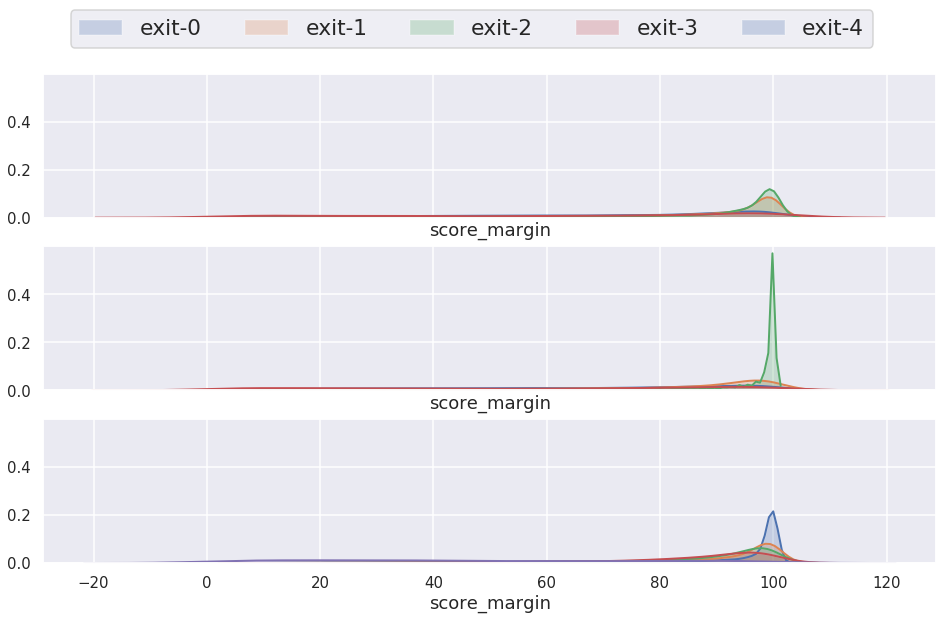

In [5]:
fig, axes = plt.subplots(3,1, figsize=(16,9), sharex=True, sharey=True)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2, 'shade': True}, hist=False, kde=True, bins=100)

for score in pc_runs['b-resnet'].groupby('exit').score_margin:
    sns.distplot(score[1]*100, ax=axes[1], **kwargs)

for score in pc_runs['b-densenet'].groupby('exit').score_margin:
    sns.distplot(score[1]*100, ax=axes[0], **kwargs)

for score in pc_runs['msdnet'].groupby('exit').score_margin:
    sns.distplot(score[1]*100, ax=axes[2], **kwargs)
fig.legend(['exit-{}'.format(x) for x in range(5)], loc='upper center', #bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=False, ncol=5, fontsize='large')


In [6]:

x = np.arange(0.1,1,0.1)
for i in x:
    df = pd.DataFrame({
            'model':models[models[2:]],
            'exit-0':np.array([ee_dense.loc[(ee_dense['exit']==0) & (ee_dense['threshold']==i)].mean().correct, 
             ee_res.loc[(ee_res['exit']==0) & (ee_res['threshold']==i)].mean().correct, 
             ee_msd.loc[(ee_msd['exit']==0) & (ee_msd['threshold']==i)].mean().correct]),
            'exit-1':np.array([ee_dense.loc[ee_dense['exit']==1].mean().correct, 
             ee_res.loc[(ee_res['exit']==1) & (ee_res['threshold']==i)].mean().correct, 
             ee_msd.loc[ee_msd['exit']==1].mean().correct]),
            'exit-2': np.array([ee_dense.loc[ee_dense['exit']==2].mean().correct, 
             ee_res.loc[ee_res['exit']==2].mean().correct, 
             ee_msd.loc[ee_msd['exit']==2].mean().correct]),
            'exit-3': np.array([ee_dense.loc[ee_dense['exit']==3].mean().correct, 
             ee_res.loc[ee_res['exit']==3].mean().correct, 
             ee_msd.loc[ee_msd['exit']==3].mean().correct]),
            'exit-4': np.array([ee_dense.loc[ee_dense['exit']==4].mean().correct, 
             ee_res.loc[ee_res['exit']==4].mean().correct, 
             ee_msd.loc[ee_msd['exit']==4].mean().correct])

    })

    df.set_index('model').plot(kind='bar')

TypeError: list indices must be integers or slices, not list

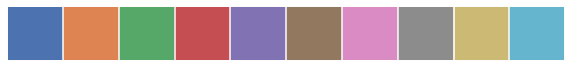

In [7]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [8]:
x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
cols=["Mean Accuracy", "Mean Time", "Std. Accuracy", "Std. Time"]
pc_runs_stats = {model: pd.DataFrame(
    columns=cols) for model in models[2:]}
pc_runs_stats

{'b-resnet': Empty DataFrame
 Columns: [Mean Accuracy, Mean Time, Std. Accuracy, Std. Time]
 Index: [], 'b-densenet': Empty DataFrame
 Columns: [Mean Accuracy, Mean Time, Std. Accuracy, Std. Time]
 Index: [], 'msdnet': Empty DataFrame
 Columns: [Mean Accuracy, Mean Time, Std. Accuracy, Std. Time]
 Index: []}

In [9]:
for model in pc_runs_stats:
    for treshold in pc_runs[model].groupby(['threshold']):
        mean = treshold[1].mean()
        std = treshold[1].std()
        pc_runs_stats[model] = pc_runs_stats[model].append(dict(zip(cols, [mean.correct, mean.time, std.correct, std.time])),ignore_index=True)
    pc_runs_stats[model] = pc_runs_stats[model].set_index(pd.Index(x))

In [10]:
time_thresholds = np.arange(0.01, 0.08, 0.003)
model_time_threshold = {
    x : {t : {} for t in time_thresholds*1000} for x in models[2:]
}
for threshold in time_thresholds:
    for model in models[2:]:
        result = pc_runs_stats[model].loc[pc_runs_stats[model]['Mean Time'] < threshold].max()
        if not np.isnan(result).any():
            model_time_threshold[model][threshold*1000]['accuracy'] = result['Mean Accuracy']
            model_time_threshold[model][threshold*1000]['time'] = result['Mean Time']*1000
        else:
            model_time_threshold[model][threshold*1000] = None

In [11]:
bresnet = pd.DataFrame(model_time_threshold['b-resnet']).T
bresnet

,accuracy,time
10.0,None,None
13.0,None,None
16.0,None,None
19.0,0.6458,17.3762
22.0,0.7352,21.0335
25.0,0.7884,23.6829
28.0,0.8226,26.2216
31.0,0.8662,29.9326
34.0,0.8842,33.7423
37.0,0.8902,36.7331


In [12]:
bdensenet = pd.DataFrame(model_time_threshold['b-densenet']).T

In [13]:
msdnet = pd.DataFrame(model_time_threshold['msdnet']).T

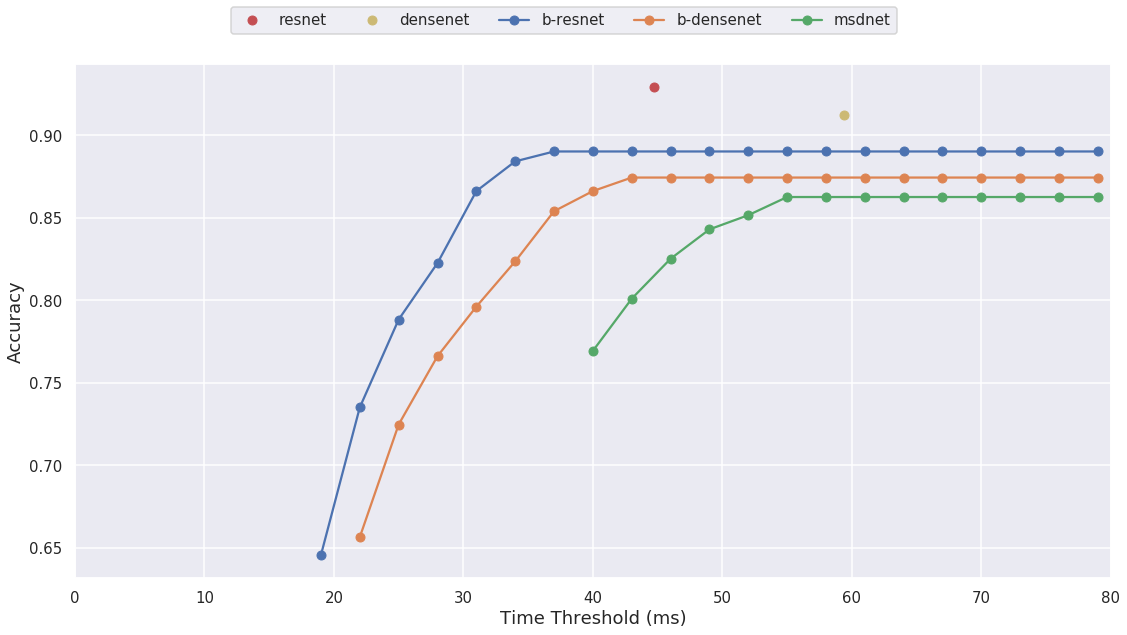

In [14]:
fig, axes = plt.subplots(1,1)
axes.plot(pc_runs['resnet'].time.mean()*1000,pc_runs['resnet'].correct.mean(),'ro') 
axes.plot(pc_runs['densenet'].time.mean()*1000,pc_runs['densenet'].correct.mean(),'yo')                  
axes.plot(bresnet['accuracy'], marker='o')
axes.plot(bdensenet['accuracy'], marker='o')
axes.plot(msdnet['accuracy'], marker='o')

fig.legend(models, ncol=5, loc="upper center", fontsize='small')
axes.set(xlabel='Time Threshold (ms)', ylabel='Accuracy')
axes.set_xlim([0,80])
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.savefig('time_threshold_pc.png')

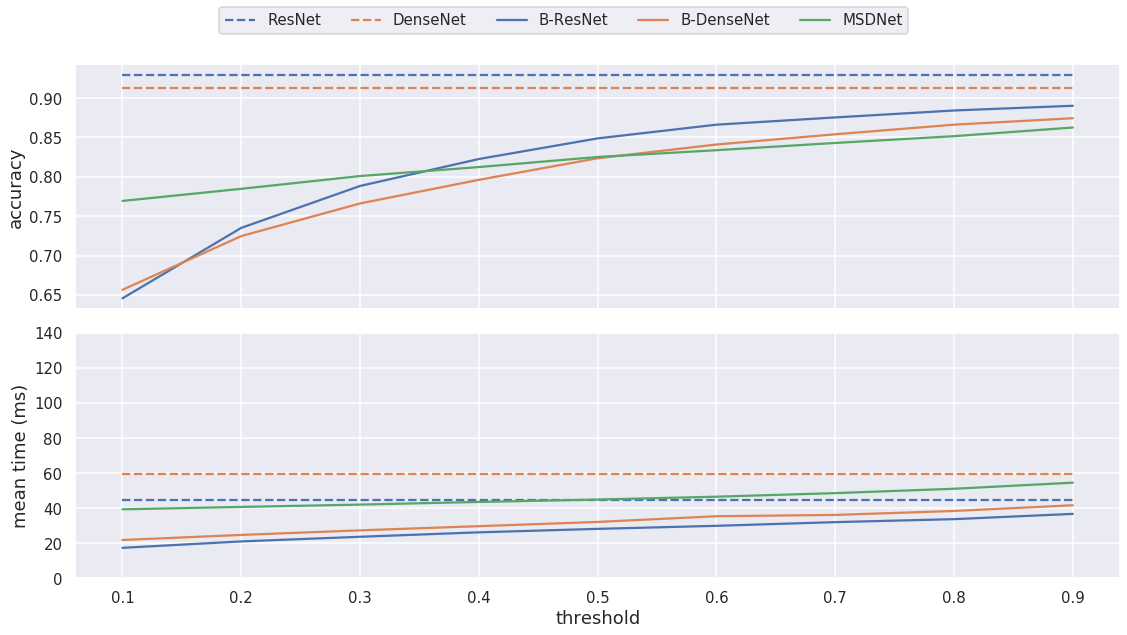

In [16]:
fig, axes = plt.subplots(2,1, sharex=True)
sns.lineplot(x=x, y=pc_runs['resnet'].correct.mean()*np.ones(9), ax=axes[0], color=current_palette[0])
sns.lineplot(x=x, y=pc_runs['resnet'].time.mean()*np.ones(9)*1000, ax=axes[1], color=current_palette[0])

sns.lineplot(x=x, y=pc_runs['densenet'].correct.mean()*np.ones(9), ax=axes[0],  color=current_palette[1])
sns.lineplot(x=x, y=pc_runs['densenet'].time.mean()*np.ones(9)*1000, ax=axes[1],  color=current_palette[1])

sns.lineplot(data=pc_runs_stats['b-resnet']['Mean Accuracy'], ax=axes[0], color=current_palette[0])
sns.lineplot(data=pc_runs_stats['b-resnet']['Mean Time']*1000, ax=axes[1], color=current_palette[0])

sns.lineplot(data=pc_runs_stats['b-densenet']['Mean Accuracy'], ax=axes[0], color=current_palette[1])
sns.lineplot(data=pc_runs_stats['b-densenet']['Mean Time']*1000, ax=axes[1], color=current_palette[1])

sns.lineplot(data=pc_runs_stats['msdnet']['Mean Accuracy'], ax=axes[0], color=current_palette[2])
sns.lineplot(data=pc_runs_stats['msdnet']['Mean Time']*1000, ax=axes[1], color=current_palette[2])

axes[0].set_ylabel('accuracy')
axes[1].set_ylabel('mean time (ms)')
plt.xlabel('threshold')



axes[0].lines[0].set_linestyle("--")

axes[1].lines[0].set_linestyle("--")

axes[0].lines[1].set_linestyle("--")

axes[1].lines[1].set_linestyle("--")

axes[1].set_ylim([0,140])


fig.legend([ 'ResNet', 'DenseNet', 'B-ResNet', 'B-DenseNet', 'MSDNet'], ncol=5, loc="upper center", fontsize='small')
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.savefig('compare_exiting_vs_no_exiting.png', dpi=300)

In [290]:
def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox.expanded(1.05,1.4))

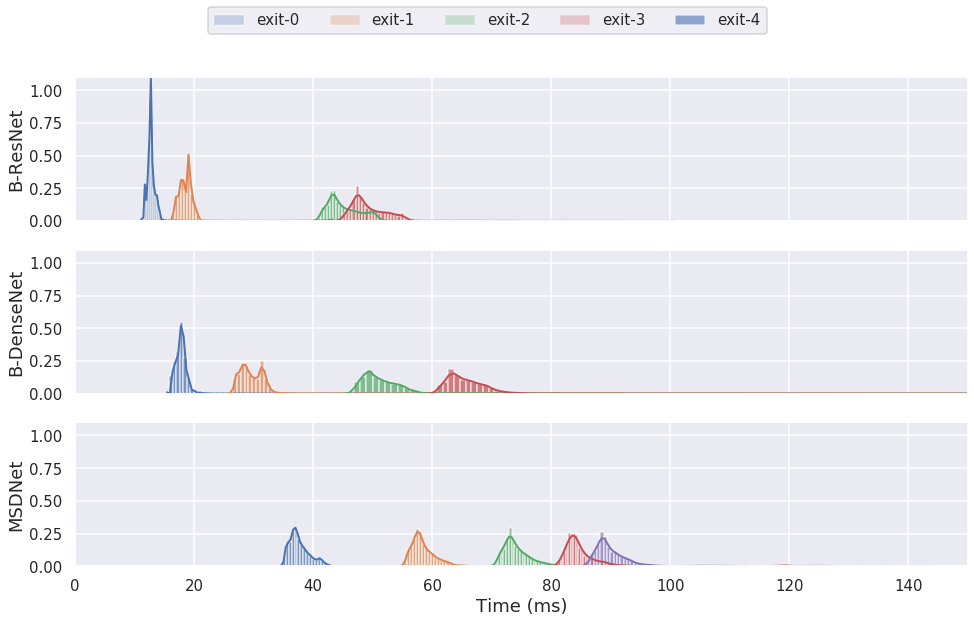

In [293]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2, 'shade': True}, hist=True, kde=True, bins=100)
fig, axes = plt.subplots(3,1, sharex=True, sharey=True)
for exit in range(4):
    sns.distplot(pc_runs['b-resnet'].loc[pc_runs['b-resnet'].exit==exit].time[1:]*1000,ax=axes[0], **kwargs)
    sns.distplot(pc_runs['b-densenet'].loc[pc_runs['b-densenet'].exit==exit].time[1:]*1000,ax=axes[1], **kwargs)
for exit in range(5):
    sns.distplot(pc_runs['msdnet'].loc[pc_runs['msdnet'].exit==exit].time[1:]*1000,ax=axes[2], **kwargs)

labels = ['B-ResNet', 'B-DenseNet', 'MSDNet']
for ax, label in zip(axes.flat, labels):
    ax.set(xlabel='Time (ms)', ylabel=label)
    ax.label_outer()
    ax.set_xlim([0,150])
    ax.set_ylim([0,1.1])
    ax.set_yticks([0,0.25,0.5,0.75,1])
plt.savefig('inference_time_distribution.png')
legend = fig.legend(['exit-{}'.format(x) for x in range(5)], ncol=5, loc="upper center", fontsize='small')
export_legend(legend,'time_dist_legend.png')

exit
0    12.869136
1    18.606198
2    45.314438
3    49.448439
Name: time, dtype: float64
exit
0    17.964638
1    29.928949
2    51.557571
3    66.200899
Name: time, dtype: float64
exit
0    38.433392
1    59.598200
2    75.701231
3    86.062633
4    91.627240
Name: time, dtype: float64


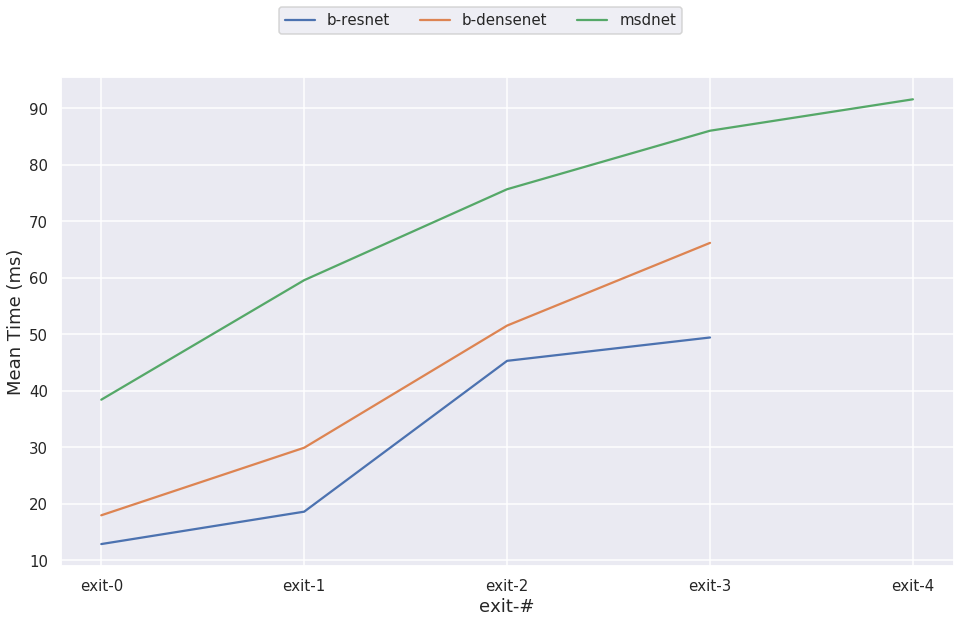

In [284]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True)
for model in models[2:]:
    time = pc_runs[model].groupby('exit').time.mean()
    print(time*1000)
    sns.lineplot(data=time*1000,ax=ax)
x = np.arange(0,5,1)
ax.set_xticks(x)
ax.set_xticklabels(['exit-{}'.format(n) for n in x])
ax.set(xlabel='exit-#', ylabel='Mean Time (ms)')
fig.legend(['{}'.format(model) for model in models[2:]], loc='upper center', #bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=False, ncol=3, fontsize='small')
plt.savefig('exit_time.png')

In [281]:
pc_runs['b-resnet'].loc[pc_runs['b-resnet'].exit==0].time[1:]

1        0.014066
2        0.014050
3        0.012749
4        0.013005
5        0.012808
           ...   
44876    0.012839
44890    0.012536
44934    0.012217
44935    0.012727
44942    0.012837
Name: time, Length: 13389, dtype: float64

In [282]:
pc_runs['densenet'].correct.mean()

0.9124

In [39]:
ee_res.exit= ee_res.exit.astype('int')
d = {    'ResNet': ee_res.groupby(['threshold', 'exit', 'correct']).size(),
         'DenseNet': ee_dense.groupby(['threshold', 'exit', 'correct']).size(),
         'MSDNet': ee_msd.groupby(['threshold', 'exit', 'correct']).size()   }
df = pd.DataFrame(d)

df = df / 5000
df

ResNet  DenseNet  MSDNet
threshold exit correct                          
0.1       0.0  0.0      0.2498    0.2608  0.2040
               1.0      0.4096    0.4782  0.7368
          1.0  0.0      0.0816    0.0672  0.0228
               1.0      0.1688    0.1578  0.0282
          2.0  0.0      0.0194    0.0138  0.0034
...                        ...       ...     ...
0.9       2.0  1.0      0.4640    0.2234  0.0686
          3.0  0.0      0.0788    0.0876  0.0106
               1.0      0.0992    0.1376  0.0256
          4.0  0.0         NaN       NaN  0.0724
               1.0         NaN       NaN  0.0522

[88 rows x 3 columns]

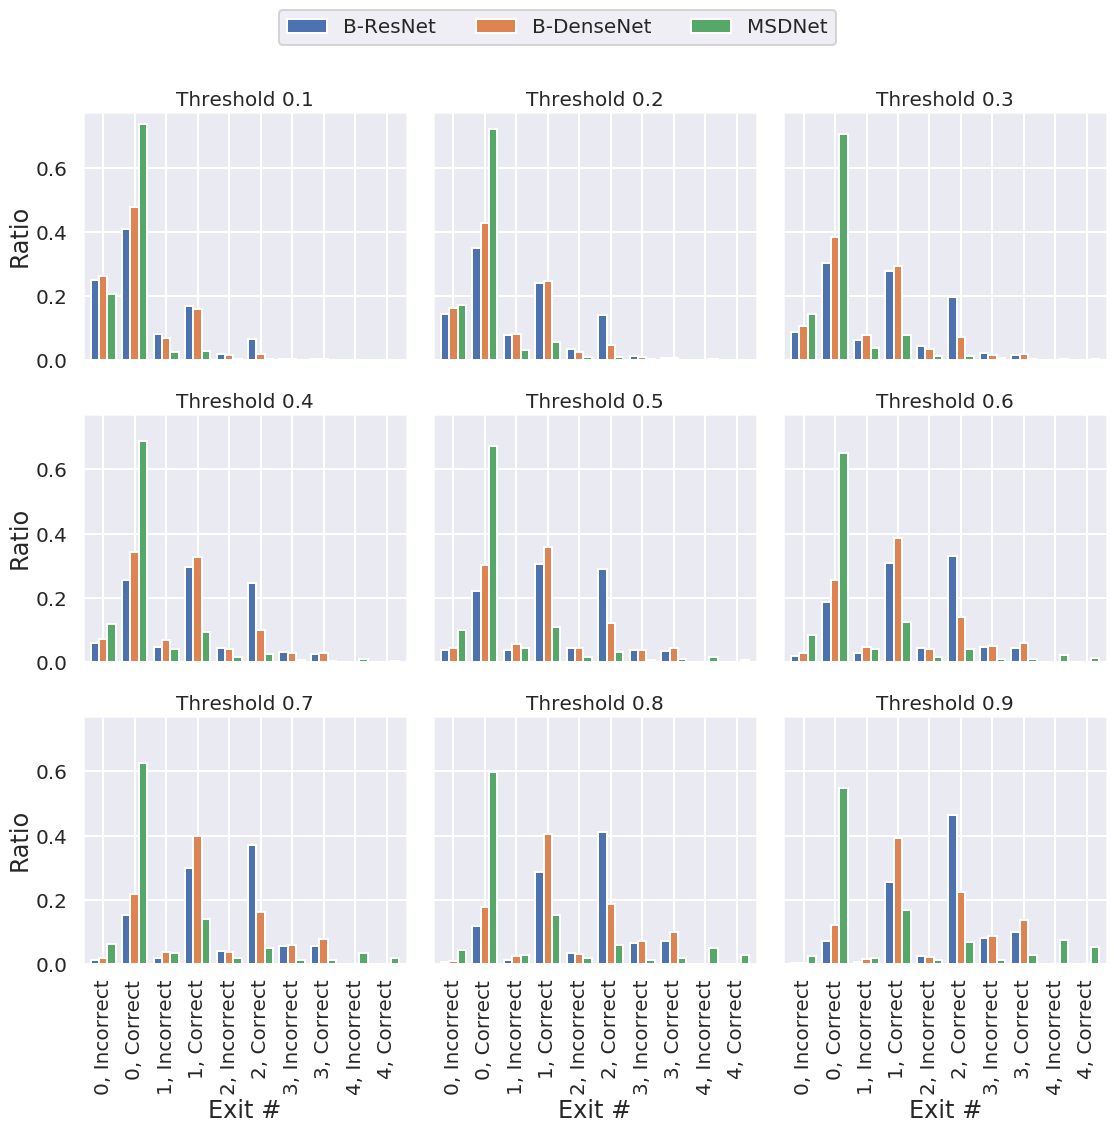

In [243]:
width=0.8
x=10
n = np.arange(x)
fig, axes = plt.subplots(3,3, sharex=True, sharey=True, figsize=(16,16))
for i, (ax, data) in enumerate(zip(axes.flat, df.groupby('threshold'))):
    #ax.set_title('Threshold {:0.1f}'.format(data[0]))
    xx = x + width/2
    #print(data[1].get('DenseNet'))
    #ax.bar(xx, np.array(data[1]['ResNet']))
    data[1].plot(kind='bar', ax=ax, legend=False, width=width)
    ax.label_outer()
    #i.xtickslabels([1, 2, 3, 4])
    ax.set(xlabel='Exit #', ylabel='Ratio', xticks=np.arange(10))
    ax.set_xticklabels(list(np.array([['{}, Incorrect'.format(exit), '{}, Correct'.format(exit)] for exit in np.arange(5)]).flatten()), fontsize='small')
    ax.set_title('Threshold {}'.format(round(data[0],1)), fontsize='small')
    #for tick in ax.get_xticklabels():
    #   tick.set_rotation(90)
        
    #ax2 = ax.secondary_xaxis('bottom')
    #ax2.xaxis.set_ticks([1,3,5,7,9])
    #ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    #ax.spines['bottom'].set_position(('outward', 36))

    #ax2.label_outer()
fig.legend(['B-ResNet', 'B-DenseNet', 'MSDNet'], ncol=3, loc='upper center', fontsize='small')
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.savefig('inference_threshold_test.png')

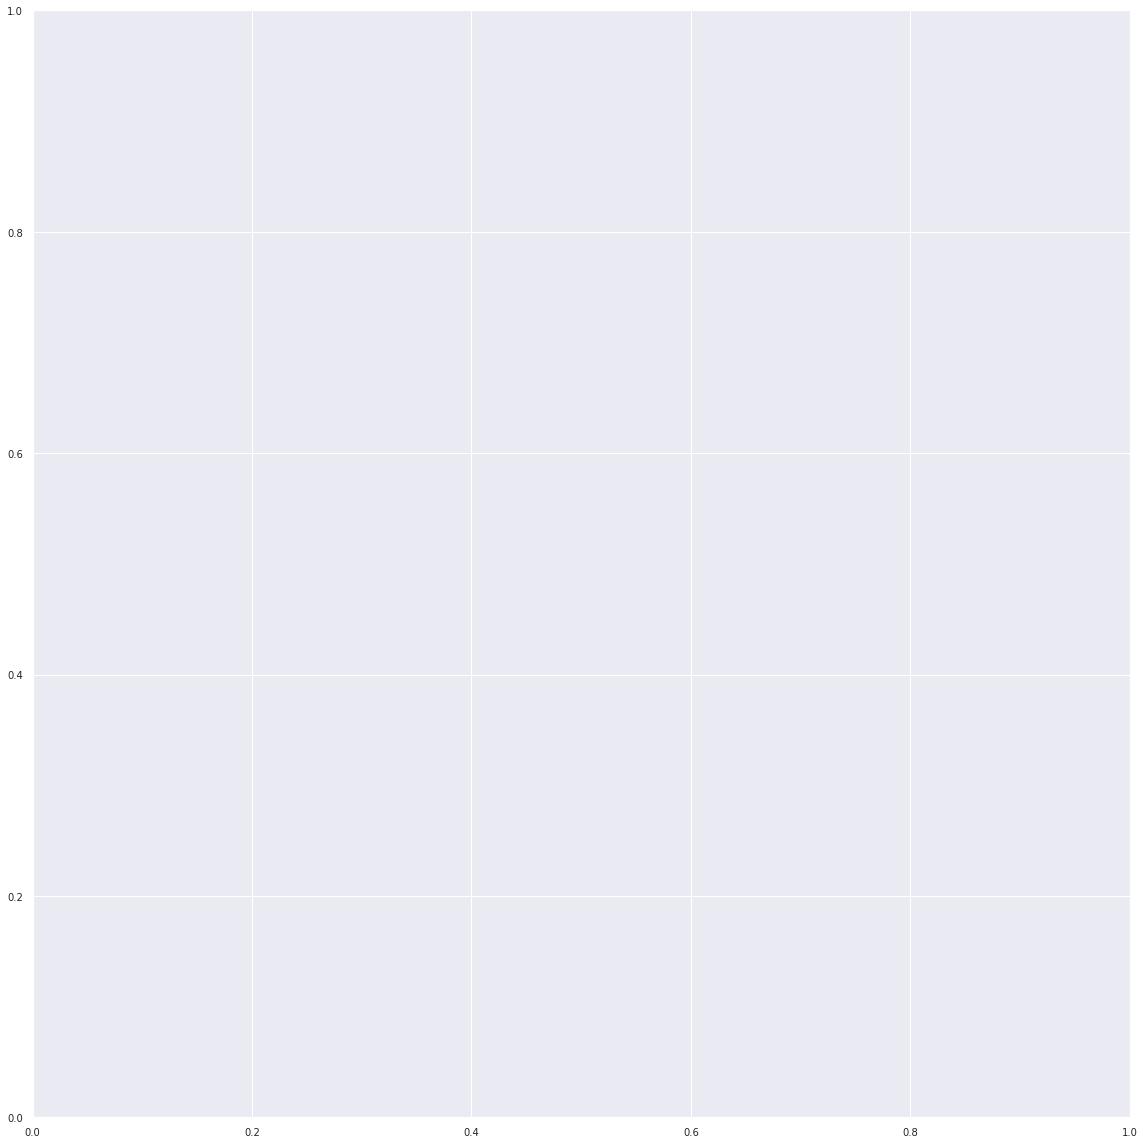

In [44]:
width=0.8
x=10
n = np.arange(x)
fig, axes = plt.subplots(1,1, sharex=True, sharey=True, figsize=(16,16))
for i, (data) in enumerate(df.groupby('threshold')):
    #ax.set_title('Threshold {:0.1f}'.format(data[0]))
    xx = x + width/2
    #print(data[1].get('DenseNet'))
    #ax.bar(xx, np.array(data[1]['ResNet']))
    data[1].plot(kind='bar', ax=ax, legend=False, width=width)
    #ax.label_outer()
    #i.xtickslabels([1, 2, 3, 4])
    ax.set(xlabel='Exit', ylabel='Ratio', xticks=np.arange(10))
    ax.set_xticklabels(list(np.array([['{}, Incorrect'.format(exit), '{}, Correct'.format(exit)] for exit in np.arange(5)]).flatten()))

    #for tick in ax.get_xticklabels():
    #   tick.set_rotation(90)
        
    #ax2 = ax.secondary_xaxis('bottom')
    #ax2.xaxis.set_ticks([1,3,5,7,9])
    #ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    #ax.spines['bottom'].set_position(('outward', 36))

    #ax2.label_outer()
#fig.legend(['B-ResNet', 'B-DenseNet', 'MSDNet'], ncol=3, loc='upper center')
fig.tight_layout()
#fig.subplots_adjust(top=0.90)
#plt.savefig('inference_threshold_test.PNG')

In [ ]:
np.arange(1,6)*0.5

In [ ]:
list(np.array([['Correct {}'.format(exit), 'Incorrect {}'.format(exit)] for exit in np.arange(5)]).flatten())

In [ ]:
df['ResNet']

In [ ]:
models = ['b-densenet', 'b-resnet', 'msdnet']
df = pd.DataFrame({
        'model':models,
        'exit-0':np.random.randn(3),
        'score2':np.random.randn(3),

                   })

df